In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle

import pandas as pd
import os

In [2]:
# In this step we wil load and preprocess our data

train_path = "/Users/zayn/Downloads/archive/Train.csv"
test_path = "/Users/zayn/Downloads/archive/Test.csv"

# Read images and labels with OpenCV
def load_data(path, is_meta=False):
    images = []
    labels = []

    # read csv file
    data = pd.read_csv(path)
    # convert to numpy array
    for idx, row in data.iterrows():
        # read img
        image_path = row['Path']
        image_path = os.path.join('/Users/zayn/Downloads/archive', image_path)
        image = cv2.imread(image_path)

        if not is_meta:
            # extract ROI: Region of Interest
            roi_x1, roi_y1, roi_x2, roi_y2 = (
                row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
            )
            # resize the ROI to desire input of CNN
            roi = image[roi_y1:roi_y2, roi_x1:roi_x2]
            roi = cv2.resize(roi, (32, 32))
            # and normalize pixel values
            roi = roi / 255.0
            images.append(roi)

            # extract labels
            label = row['ClassId']
            labels.append(label)
        else:
            # shape_id = row['ShapeId']
            # color_id = row['ColorId']
            # sign_id = row['SignId']
            # meta_data = [shape_id, color_id, sign_id]

            resized_image = cv2.resize(image, (32, 32))
            resized_image = resized_image / 255.0

            images.append(resized_image)

            label = row['ClassId']
            labels.append(label)

    return np.array(images), np.array(labels)

x_train, y_train = load_data(train_path, is_meta=False)
x_test, y_test = load_data(test_path, is_meta=False)

# load meta data
meta_path = "/Users/zayn/Downloads/archive/Meta.csv"
x_meta, y_meta = load_data(meta_path, is_meta=True)


# # now we will normalize pixels values to be between 0 and 1
# x_train, x_meta, x_test = x_train / 255.0, x_meta / 255.0, x_test / 255.0

In [3]:
x_train, y_train = shuffle(x_train, y_train)

In [4]:
# In this step we will build a CNN model
model = models.Sequential() # create a squential model, linear stack of layers into a tf.keras.Model

# this model achieved loss: 0.3628 - accuracy: 0.9508; val_loss: 6.9701 - val_accuracy: 0.6744
# These layers will define our architecture and can be adjusted based on our requirements
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(43, activation='softmax'))   # this is the number of our classes


# Dev's model, I didn't change images to 1D though, keep 3rd dim
# Layer 1
model.add(layers.Conv2D(20, (3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D())

model.add(layers.Dropout(0.2))

# Layer 2
model.add(layers.Conv2D(30, (3,3), activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Dropout(0.2))

# Layer 3
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.Dense(256, activation='relu'))

#Layer 4
model.add(layers.Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 20)        560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 20)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 30)        5430      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 30)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 30)          0

In [5]:
# In this step we will compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Now train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data =(x_meta, y_meta), verbose=1)

Epoch 1/10


2023-11-26 01:12:46.470430: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1226/1226 [==============================] - 10s 8ms/step - loss: 1.0229 - accuracy: 0.7236 - val_loss: 2.5825 - val_accuracy: 0.6512
Epoch 2/10
1226/1226 [==============================] - 9s 8ms/step - loss: 0.2645 - accuracy: 0.9426 - val_loss: 2.7758 - val_accuracy: 0.6977
Epoch 3/10
1226/1226 [==============================] - 11s 9ms/step - loss: 0.1910 - accuracy: 0.9653 - val_loss: 2.8042 - val_accuracy: 0.6744
Epoch 4/10
1226/1226 [==============================] - 13s 10ms/step - loss: 0.1603 - accuracy: 0.9730 - val_loss: 2.5086 - val_accuracy: 0.7674
Epoch 5/10
1226/1226 [==============================] - 14s 11ms/step - loss: 0.1434 - accuracy: 0.9787 - val_loss: 3.3865 - val_accuracy: 0.7674
Epoch 6/10
1226/1226 [==============================] - 12s 10ms/step - loss: 0.1328 - accuracy: 0.9807 - val_loss: 2.5049 - val_accuracy: 0.7907
Epoch 7/10
1226/1226 [==============================] - 13s 10ms/step - loss: 0.1321 - accuracy: 0.9818 - val_loss: 2.3461 - val_accuracy: 

In [7]:
# Epoch: This is one complete pass through the entire training datset
# Batch: During each epoch, the dataset is divided into batches, and the model is updated after each batch
# Loss: This is the value of the loss function on the training dataset, it represents how well the model is performing on training data, goal is to minimize this
# Accuracy: This is the accuracy of the model on the traning dataset. It represents the percentage of the correctly classified samples.
# val_loss: This is the value of the loss function on the validation dataset (meta data). The validation dataset is not used for training, it serves as indepedent
            # dataset to evaluate how well the model generalizes to new, unseen data
# val_accuracy: this is the accuracy of the model on the validation dataset. It's similar to training accuracy, but is valuclated on the validation data.
            # 67.44% accuracy on unseen data can be seen at pretty low

# We might be overfitting, we learned training data too closely.

In [8]:
# Lets evaluate our models and make some predictions over our test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

395/395 [==============================] - 2s 4ms/step - loss: 0.2647 - accuracy: 0.9536
Test accuracy: 0.9536025524139404


In [9]:
predictions = model.predict(x_test)

395/395 [==============================] - 2s 4ms/step


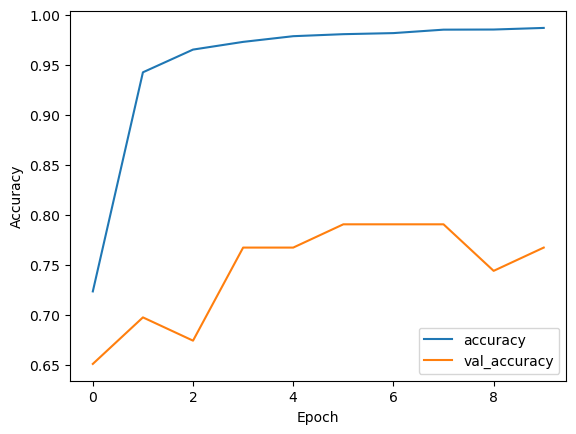

In [10]:
# plot some data
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [11]:
# Lets write a function to visualize model predictions and ground truth labels

def visualize_predictions(images, true_labels, predictions, class_names):
    num_images = min(43, len(images))   # Visualize up to 43 images
    num_cols = min(5, num_images)       # Adjust the number of columns based on your preference
    num_rows = (num_images - 1) // num_cols + 1 
 
    plt.figure(figsize=(15, 10))
    for i in range(num_images):  # Visualize up to 10 images
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[np.argmax(predictions[i])]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

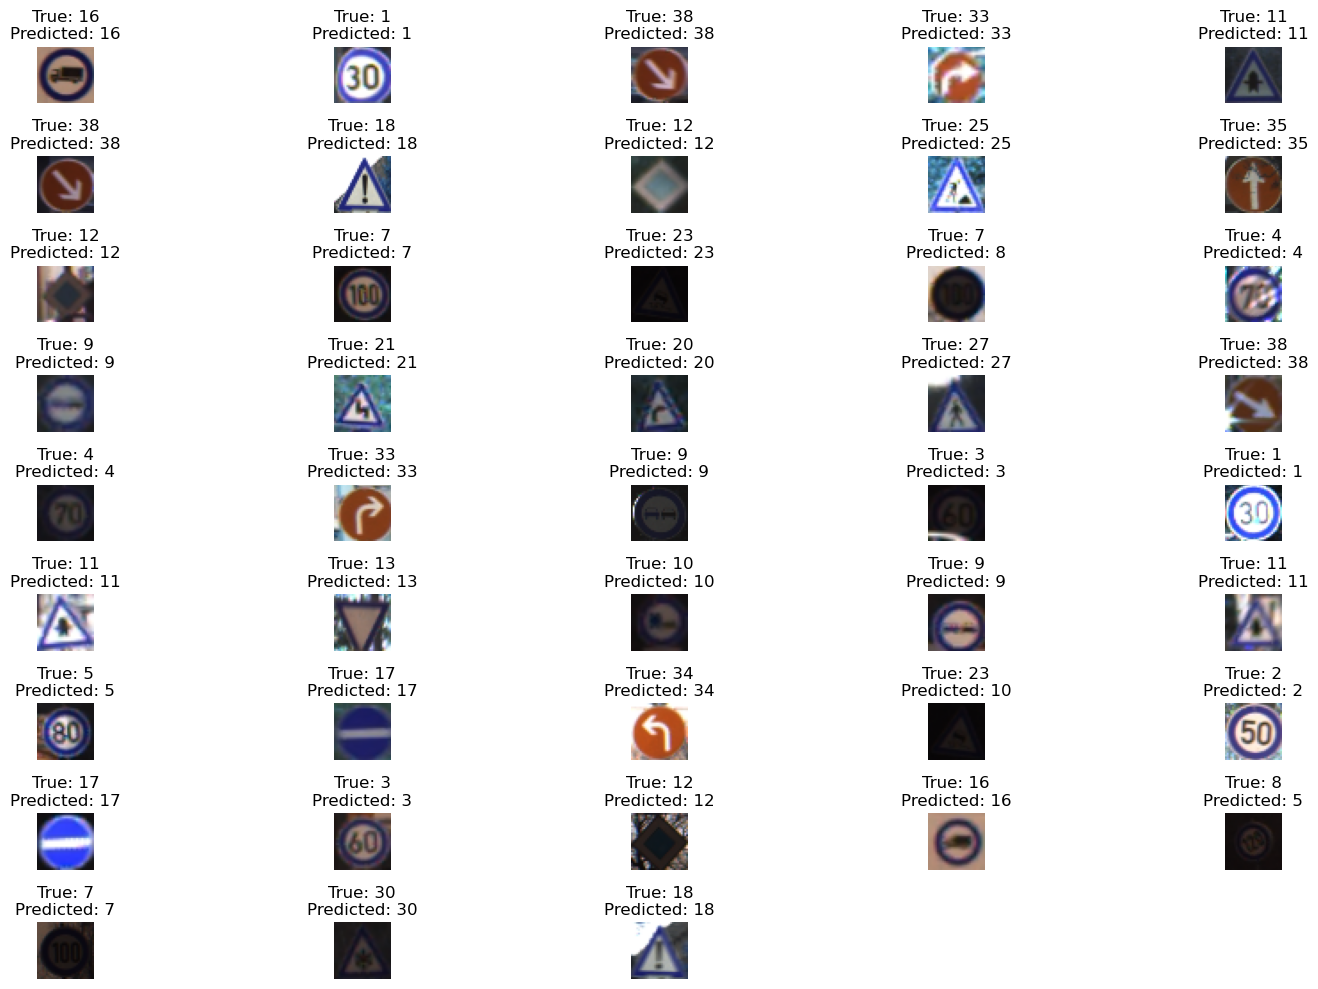

In [12]:
# display some predictions

class_names = [i for i in range(43)]

visualize_predictions(x_test, y_test, predictions, class_names)

In [15]:
# We should save our model for use in a video classification script
# model.save('sign_model.h5')
model.save('sign_model.keras')